In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
from scipy.signal import correlate, fftconvolve, correlate
from scipy.stats import norm, kendalltau, spearmanr, pearsonr
from scipy.optimize import curve_fit
from tqdm import tqdm

from Week18Overview import H2O_wl

In [ ]:
def add_noise(flux, SNR=300):
    """
    SNR = flux/sigma
    """
    noise_level = np.min(flux) / SNR
    noise = np.random.normal(0, noise_level, size=flux.shape)
    return flux + noise


def shift_array(arr, n, fill_value=0):
    """Shift an array by n elements (left or right)."""
    result = np.empty_like(arr)
    if n > 0:
        result[:n] = fill_value
        result[n:] = arr[:-n]
    elif n < 0:
        result[n:] = fill_value
        result[:n] = arr[-n:]
    else:
        result[:] = arr
    return result


def detect_molecule(wavelength, spectrum, specie_spectrum, clip_min=4.9, clip_max=27.5, peak_shift=0, window=300,
                    exclude=20):
    if len(wavelength) != len(spectrum) | len(wavelength) != len(specie_spectrum):
        print('Error: wavelength, spectrum and specie_spectrum must be the same length')
        return

    feature_mask = np.logical_and(wavelength > clip_min, wavelength < clip_max)

    # center_index = len(wavelength[feature_mask]) // 2

    lags = np.arange(-len(spectrum[feature_mask]) + 1, len(spectrum[feature_mask]))
    cc = correlate(spectrum[feature_mask], specie_spectrum[feature_mask], mode='full')
    ac = correlate(specie_spectrum[feature_mask], specie_spectrum[feature_mask], mode='full')
    ac /= ac[len(ac) // 2]
    center_index = len(lags) // 2
    lag_indices = np.arange(center_index - window, center_index + window + 1)

    # plt.plot(correlate(ac, cc))
    # plt.show()
    X = ac[lag_indices]
    Y = cc[lag_indices]
    X = shift_array(X, peak_shift)
    print(pearsonr(X, Y))
    lags_window = lags[lag_indices] - lags[center_index + peak_shift]
    noise_mask = (lags_window < -exclude) | (lags_window > exclude)

    weights = np.exp(-(lags_window) ** 2 / 2)
    # print(weights)
    factor = np.sum(weights[~noise_mask]*X[~noise_mask]*Y[~noise_mask])/np.sum(weights[~noise_mask]*X[~noise_mask]**2)
    model = factor * X
    residual = Y - model


    sigma_noise = np.std(residual[noise_mask])

    Z = factor / sigma_noise
    p = 1 - norm.cdf(Z)
    plt.plot(lags_window, Y, label='Cross-correlation')
    plt.plot(lags_window, model, label='Fitted tiny signal')
    plt.plot(lags_window, residual, label='Residual')
    plt.axvline(peak_shift, color='gray', linestyle='--', label='Peak')
    plt.axhline(0, color='gray', linestyle=':')
    plt.axvline(-exclude, color='red', linestyle='--')
    plt.axvline(exclude, color='red', linestyle='--')
    plt.title(f'Cross-correlation Analysis\nZ-score at lag=0 = {Z:.2f}')
    plt.xlabel('Lag')
    plt.ylabel('Correlation')
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
    # plt.xlim(-exclude, exclude)
    plt.grid(True)
    return Z, p

In [ ]:
with open('FLiTsData1000_N.pkl', 'rb') as f:
    df = pickle.load(f)
print(df.columns)

In [ ]:
species = ['atomic', 'C2H2', 'CH4', 'CO', 'CO2', 'H2O', 'HCN', 'NH3', 'NO', 'OH']
species = ['H2O']
target = 'H2O'
total_wl = np.linspace(4.9, 27.5, 10000)
clip_min, clip_max = 4.9, 27.5
for target in species:
    for i, row in df.iterrows():
        if i != 2:
            continue
        wavelength = row['FLiTs Wavelength']
        flux_cont_sub = row['FLiTs Flux']
        continuum = row['FLiTs Flux Continuum']
        flux_cont_sub = np.interp(total_wl, wavelength, flux_cont_sub)
        continuum = np.interp(total_wl, wavelength, continuum)
        flux_cont_sub = add_noise(flux_cont_sub + continuum, SNR=300) - continuum
        target_wl = row[f'FLiTs {target} Wavelength']
        target_flux = row[f'FLiTs {target} Flux']
        target_flux = np.interp(total_wl, target_wl, target_flux)
        plt.plot(total_wl, flux_cont_sub)
        plt.plot(total_wl, target_flux)
        plt.title(f'{target} spectrum')
        plt.xlim(clip_min, clip_max)
        plt.ylim(0, 0.1)
        plt.show()
        detect_molecule(total_wl, flux_cont_sub, target_flux, clip_min=clip_min, clip_max=clip_max, peak_shift=0,
                        window=100,
                        exclude=20)
        plt.show()
        detect_molecule(total_wl, flux_cont_sub - target_flux, target_flux, clip_min=clip_min, clip_max=clip_max,
                        peak_shift=0, window=100,
                        exclude=20)
        plt.show()

In [ ]:
def new_detect_molecule(wavelength, spectrum, specie_spectrum, clip_min=4.9, clip_max=27.5, peak_shift=0, window=300,
                    exclude=20, title=None, plot=False, n_trials=1000):
    if len(wavelength) != len(spectrum) | len(wavelength) != len(specie_spectrum):
        print('Error: wavelength, spectrum and specie_spectrum must be the same length')
        return

    feature_mask = np.logical_and(wavelength > clip_min, wavelength < clip_max)

    # center_index = len(wavelength[feature_mask]) // 2

    lags = np.arange(-len(spectrum[feature_mask]) + 1, len(spectrum[feature_mask]))
    cc = correlate(spectrum[feature_mask], specie_spectrum[feature_mask], mode='full')
    ac = correlate(specie_spectrum[feature_mask], specie_spectrum[feature_mask], mode='full')
    ac /= ac[len(ac) // 2]
    center_index = len(lags) // 2
    lag_indices = np.arange(center_index - window, center_index + window + 1)

    # plt.plot(correlate(ac, cc))
    # plt.show()
    X = ac[lag_indices]
    Y = cc[lag_indices]
    X = shift_array(X, peak_shift)
    # print(pearsonr(X, Y))
    lags_window = lags[lag_indices] - lags[center_index + peak_shift]
    noise_mask = (lags_window < -exclude) | (lags_window > exclude)

    weights = np.exp(-(lags_window) ** 2 / 2)
    # print(weights)
    factor = np.sum(X[~noise_mask]*Y[~noise_mask])/np.sum(X[~noise_mask]**2)
    model = factor * X
    residual = Y - model

    mid = len(Y) // 2
    test_s = Y[mid]-np.median(Y[~noise_mask])
    test_s_list = []
    for _ in range(n_trials):
        # shift = np.random.randint(1, len(spectrum[feature_mask]))  # avoid shift = 0
        # spectrum_shifted = np.roll(spectrum[feature_mask], shift)
        cc_new = correlate(np.random.choice(spectrum[feature_mask], size=len(spectrum[feature_mask]), replace=True), specie_spectrum[feature_mask], mode='full')
        # factor = np.sum(X[~noise_mask]*cc_new[lag_indices][~noise_mask])/np.sum(X[~noise_mask]**2)
        # model = factor * X
        # plt.plot(lags[lag_indices], cc_new[lag_indices])
        # plt.plot(lags[lag_indices], cc[lag_indices])
        # plt.show()
        test_s_list.append(cc_new[lag_indices][mid]-np.median(cc_new[lag_indices][~noise_mask]))
    test_s_list = np.array(test_s_list)
    p = round(1 - len(test_s_list[test_s_list<test_s])/n_trials, int(np.log10(n_trials)))
    if plot:
        plt.plot(lags_window, Y, label='Cross-correlation')
        # plt.plot(lags_window, X*Y[mid], label='Fitted Auto-correlation')
        # # plt.plot(lags_window, residual, label='Residual')
        # plt.axvline(peak_shift, color='gray', linestyle='--', label='Peak')
        # plt.axhline(0, color='gray', linestyle=':')
        # plt.axvline(-exclude, color='red', linestyle='--')
        # plt.axvline(exclude, color='red', linestyle='--', label='Window')
        # plt.title(f'Cross-correlation {title}')
        plt.xlabel('Lag')
        plt.ylabel('Correlation [a.u.]')
        # plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
        plt.xlim(-window, window)
        plt.grid(True)
        # plt.show()
        # plt.title(title + ' ' + str(p))
        # plt.hist(test_s_list, density=True)
        # plt.axvline(test_s, color='red')
        # plt.xlabel('Difference Peak and Median')
        # plt.ylabel('Probability Density')
        # plt.show()
    return p

In [ ]:
species = ['atomic', 'C2H2', 'CH4', 'CO', 'CO2', 'H2O', 'HCN', 'NH3', 'NO', 'OH']
colors = {'atomic': 'tomato', 'C2H2': 'yellow', 'CH4': 'mediumorchid', 'CO': 'red', 'CO2': 'limegreen', 'H2O': 'dodgerblue',
          'HCN': 'orange', 'NH3': 'cyan', 'NO': 'gold', 'OH': 'magenta'}
avg_flux = {}
total_wl = np.linspace(4.9, 27.5, 10000)
for specie in species:
    total_flux = np.zeros_like(total_wl)
    for i,row in df.iterrows():
        specie_wl = row[f'FLiTs {specie} Wavelength']
        specie_flux = row[f'FLiTs {specie} Flux']
        specie_flux = np.interp(total_wl, specie_wl, specie_flux)
        total_flux += specie_flux
    total_flux /= max(total_flux)
    avg_flux.update({specie:total_flux})

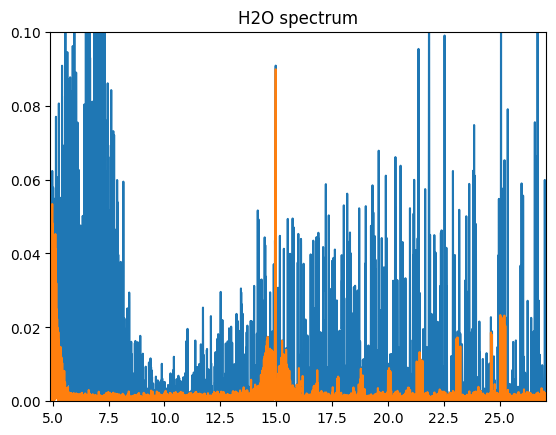

C_0.0_O_0.0_CO_0.45 ------------
H2O Present:  True


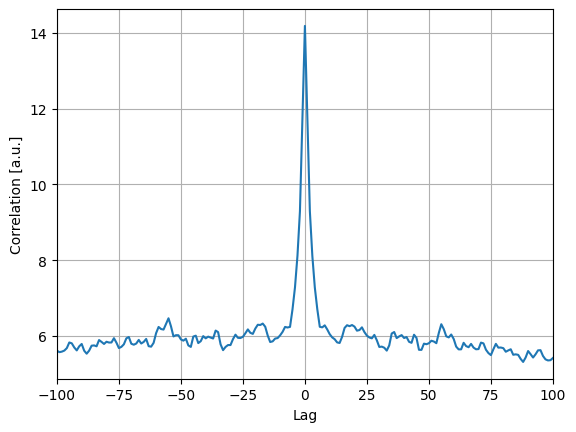

H2O Not Present:  False


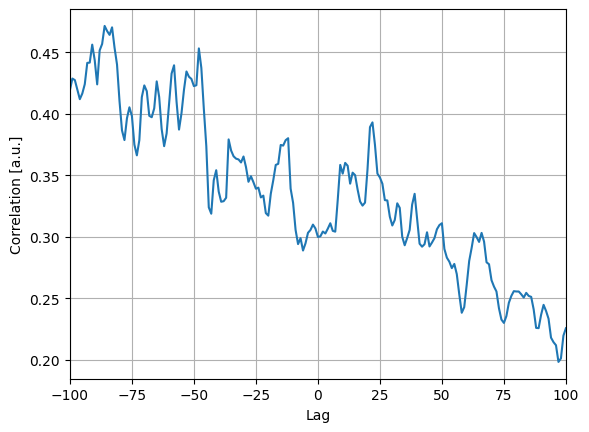

In [212]:
species = ['C2H2', 'CH4', 'CO', 'CO2', 'H2O', 'HCN', 'NH3', 'NO', 'OH']
species = ['H2O']
target = 'H2O'
total_wl = np.linspace(4.9, 27.5, 10000)
# clip_min, clip_max = 4.9, 6
for target in species:
    for i, row in df.iterrows():
        if i != 12:
            continue
        clip_min, clip_max = species_ranges[target]
        wavelength = row['FLiTs Wavelength']
        flux_cont_sub = row['FLiTs Flux']
        continuum = row['FLiTs Flux Continuum']
        NH3_wl = row['FLiTs NH3 Wavelength']
        NH3_flux = row['FLiTs NH3 Flux']
        NH3_flux = np.interp(total_wl, NH3_wl, NH3_flux)
        flux_cont_sub = np.interp(total_wl, wavelength, flux_cont_sub) + NH3_flux
        continuum = np.interp(total_wl, wavelength, continuum)
        flux_cont_sub = add_noise(flux_cont_sub + continuum, SNR=300) - continuum
        real_wl = row[f'FLiTs {target} Wavelength']
        real_flux = row[f'FLiTs {target} Flux']
        real_flux = np.interp(total_wl, real_wl, real_flux)
        target_flux = avg_flux[target]
        plt.plot(total_wl, flux_cont_sub)
        plt.plot(total_wl, flux_cont_sub-real_flux)
        plt.title(f'{target} spectrum')
        plt.xlim(clip_min, clip_max)
        plt.ylim(0, 0.1)
        plt.show()
        print(row['Model Name'], '------------')
        print(target + ' Present: ', new_detect_molecule(total_wl, flux_cont_sub, target_flux, clip_min=clip_min, clip_max=clip_max, peak_shift=0,
                        window=100,
                        exclude=99, title=f'{target}Present', plot=True)<0.05)
        plt.savefig('Figures/Cross-Correlation.pdf', bbox_inches='tight')
        plt.show()
        print(target + ' Not Present: ', new_detect_molecule(total_wl, flux_cont_sub-real_flux, target_flux, clip_min=clip_min, clip_max=clip_max,
                        peak_shift=0, window=100,
                        exclude=99, title=f'{target}Not Present', plot=True)<0.05)
        # plt.show()

In [ ]:
species = ['atomic', 'C2H2', 'CH4', 'CO', 'CO2', 'H2O', 'HCN', 'NH3', 'NO', 'OH']
species = ['NO']
# target = 'H2O'
total_wl = np.linspace(4.9, 27.5, 10000)
# clip_min, clip_max = 4.9, 27.5
for target in species:
    for i, row in df.iterrows():
        if i != 12:
            continue
        clip_min, clip_max = species_ranges[target]
        wavelength = row['FLiTs Wavelength']
        flux_cont_sub = row['FLiTs Flux']
        continuum = row['FLiTs Flux Continuum']
        NH3_wl = row['FLiTs NH3 Wavelength']
        NH3_flux = row['FLiTs NH3 Flux']
        NH3_flux = np.interp(total_wl, NH3_wl, NH3_flux)
        flux_cont_sub = np.interp(total_wl, wavelength, flux_cont_sub) + NH3_flux
        continuum = np.interp(total_wl, wavelength, continuum)
        flux_cont_sub = add_noise(flux_cont_sub + continuum, SNR=300) - continuum
        real_wl = row[f'FLiTs {target} Wavelength']
        real_flux = row[f'FLiTs {target} Flux']
        real_flux = np.interp(total_wl, real_wl, real_flux)
        CO_wl = row['FLiTs CO Wavelength']
        CO_flux = row['FLiTs CO Flux']
        CO_flux = np.interp(total_wl, CO_wl, CO_flux)
        H2O_wl = row['FLiTs H2O Wavelength']
        H2O_flux = row['FLiTs H2O Flux']
        H2O_flux = np.interp(total_wl, H2O_wl, H2O_flux)
        target_flux = avg_flux[target]
        # plt.plot(total_wl, real_flux)
        plt.plot(total_wl, flux_cont_sub-H2O_flux-CO_flux)
        plt.title(f'{target} spectrum')
        plt.xlim(clip_min, clip_max)
        plt.ylim(0, 0.02)
        plt.show()
        print(row['Model Name'], '------------')
        print(target + ' Full: ', new_detect_molecule(total_wl, flux_cont_sub, target_flux, clip_min=clip_min, clip_max=clip_max, peak_shift=0,
                        window=100,
                        exclude=99, title=f'{target}Present', n_trials=10000))
        # plt.show()
        print(target + ' Full-H2O: ', new_detect_molecule(total_wl, flux_cont_sub-H2O_flux, target_flux, clip_min=clip_min, clip_max=clip_max,
                        peak_shift=0, window=100,
                        exclude=99, title=f'{target}Not Present', n_trials=10000))
        print(target + ' Full-CO: ', new_detect_molecule(total_wl, flux_cont_sub-CO_flux, target_flux, clip_min=clip_min, clip_max=clip_max,
                        peak_shift=0, window=100,
                        exclude=99, title=f'{target}Not Present', n_trials=10000))
        print(target + ' Full-H2O-CO: ', new_detect_molecule(total_wl, flux_cont_sub-H2O_flux-CO_flux, target_flux, clip_min=clip_min, clip_max=clip_max,
                        peak_shift=0, window=100,
                        exclude=99, title=f'{target}Not Present', n_trials=10000))
        # plt.show()

In [ ]:
species = ['atomic', 'C2H2', 'CH4', 'CO', 'CO2', 'H2O', 'HCN', 'NH3', 'NO', 'OH']
species = ['OH']
for specie in species:
    plt.plot(total_wl, avg_flux[specie], color=colors[specie], label=specie)
plt.legend()
plt.show()

In [ ]:
def trim_flat_edges(x, y, tol=1e-8):
    """
    Returns the shortest x-range that excludes flat regions of y on both ends.
    `tol` defines how much change in y is considered a 'real' change.
    """
    y = np.asarray(y)
    x = np.asarray(x)

    # Find index from left where y starts changing
    left = 0
    while left < len(y) - 1 and np.abs(y[left + 1] - y[left]) < tol:
        left += 1

    # Find index from right where y starts changing
    right = len(y) - 1
    while right > 0 and np.abs(y[right] - y[right - 1]) < tol:
        right -= 1

    # Extract the trimmed x-range
    x_trimmed = x[left:right+1]
    y_trimmed = y[left:right+1]

    return [left, right]

In [ ]:
import math
species = ['atomic', 'C2H2', 'CH4', 'CO', 'CO2', 'H2O', 'HCN', 'NH3', 'NO', 'OH']
species_ranges = {}
for specie in species:
    species_ranges.update({specie:[math.floor(total_wl[trim_flat_edges(total_wl, avg_flux[specie], tol=1e-10)[0]]*10)/10,math.ceil(total_wl[trim_flat_edges(total_wl, avg_flux[specie], tol=1e-1)[1]]*10)/10]})





In [ ]:
print(species_ranges)

In [ ]:
for specie in species:
    mask = (total_wl > species_ranges[specie][0]) & (total_wl < species_ranges[specie][1])
    plt.plot(total_wl[mask], avg_flux[specie][mask], color=colors[specie], label=specie)
    plt.show()